# TM10007 Assignment template

In [17]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [13]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
#from worcliver.load_data import load_data
#from ecg.load_data import load_data
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn as sns
import os

# Classifiers
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter  # For smoothing
from scipy.stats import shapiro
from scipy.signal import find_peaks

def load_data():
    this_directory = os.getcwd()
    data = pd.read_csv(os.path.join(this_directory, 'Lipo_radiomicFeatures_with_nans.csv'), index_col=0)
    return data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Load the dataset
file_path = "data_with_nans.csv"  # Ensure the dataset is in the same directory as the notebook
df = pd.read_csv(file_path)

# Display basic info and first few rows
df.info()
df.head()

The number of samples: 115
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Columns: 495 entries, ID to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(493), object(2)
memory usage: 444.9+ KB


,ID,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
0,Lipo-001_0,liposarcoma,0.368434,0.262371,26.200395,8.174390,20.940000,13.551937,0.694139,0.227848,...,0.049726,0.196019,0.927821,-0.407270,0.0,0.0,0.625304,3238.304991,0.315148,14.462361
1,Lipo-002_0,liposarcoma,0.660571,0.179013,55.155046,9.318741,9.546044,7.051937,0.871182,0.125279,...,0.036186,0.167471,1.137972,0.411968,0.0,0.0,0.563659,15364.724390,0.251255,17.170274
2,Lipo-003_0,lipoma,0.365191,0.157712,30.577026,8.963647,17.695139,10.772365,0.704710,0.137529,...,0.128167,0.220546,0.829650,-0.520344,0.0,0.0,0.705679,3771.798158,0.369366,14.394812
3,Lipo-004_0,liposarcoma,0.372210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,10.399652,0.0,0.0,0.438399,NaN,0.000000,NaN
4,Lipo-005_0,NaN,NaN,NaN,NaN,NaN,17.059573,NaN,NaN,NaN,...,NaN,NaN,3.284943,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# # Check for missing values
# missing_values=[]
# index = 0
# for row in df:
#     for elem in row:
#         if elem is None:
#             missing_values[row] = df[row,:]
#             index += 1

# if missing_values:
#     print(f"Missing values stored in missing_values")

# Check for missing values and store them
missing_values = df[df.isna().any(axis=1)]

if not missing_values.empty:
    print("Missing values stored in missing_values")
else:
    print("No missing values found")

df = df.drop(missing_values.iloc[0:,:].index)

# Encode the target variable
df['label'] = df['label'].map({'lipoma': 0, 'liposarcoma': 1})

# Drop ID column as it is not useful for training
df.drop(columns=['ID'], inplace=True)

# Display dataset after preprocessing
df.head()

Missing values stored in missing_values


,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
0,1,0.368434,0.262371,26.200395,8.174390,20.940000,13.551937,0.694139,0.227848,0.096312,...,0.049726,0.196019,0.927821,-0.407270,0.0,0.0,0.625304,3238.304991,0.315148,14.462361
1,1,0.660571,0.179013,55.155046,9.318741,9.546044,7.051937,0.871182,0.125279,0.030465,...,0.036186,0.167471,1.137972,0.411968,0.0,0.0,0.563659,15364.724390,0.251255,17.170274
2,0,0.365191,0.157712,30.577026,8.963647,17.695139,10.772365,0.704710,0.137529,0.088020,...,0.128167,0.220546,0.829650,-0.520344,0.0,0.0,0.705679,3771.798158,0.369366,14.394812
5,0,0.530722,0.046355,35.539888,12.782344,25.545428,11.830081,0.974262,0.017478,0.130681,...,0.083116,0.216769,0.680896,-0.997185,0.0,0.0,0.648043,1453.698755,0.385779,13.009949
6,0,0.578484,0.228331,46.472385,13.170538,15.825059,14.474947,0.861070,0.174254,0.082681,...,0.000000,0.101188,2.212027,4.659459,0.0,0.0,0.383949,1424.177299,0.070181,14.748361


In [15]:
# Scaling
scaler = preprocessing.MinMaxScaler()
for column in df.columns[1:]:
    column_data = df[column].values
    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        scaler = preprocessing.RobustScaler()

df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [16]:
# Split into train and test
X = df
y = df.iloc[:, 0]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y)

In [17]:
# Feature selection based on variance
variance_selector = VarianceThreshold(threshold=0.01)
data_var= variance_selector.fit_transform(X_train.iloc[:, 1:])

print(f'The number of columns after variance selection: {(data_var.shape[1])}')
print(f'The number of rows after variance selection: {(data_var.shape[0])}')

The number of columns after variance selection: 467
The number of rows after variance selection: 83


In [18]:
# Apply PCA based on them to explain 99% of the data
pca = decomposition.PCA(n_components= 0.9999999999999999)
data_pca = pca.fit_transform(data_var)

print(f'The number of columns after variance selection: {(data_pca.shape[1])}')
print(f'The number of rows after variance selection: {(data_pca.shape[0])}')

The number of columns after variance selection: 82
The number of rows after variance selection: 83


/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

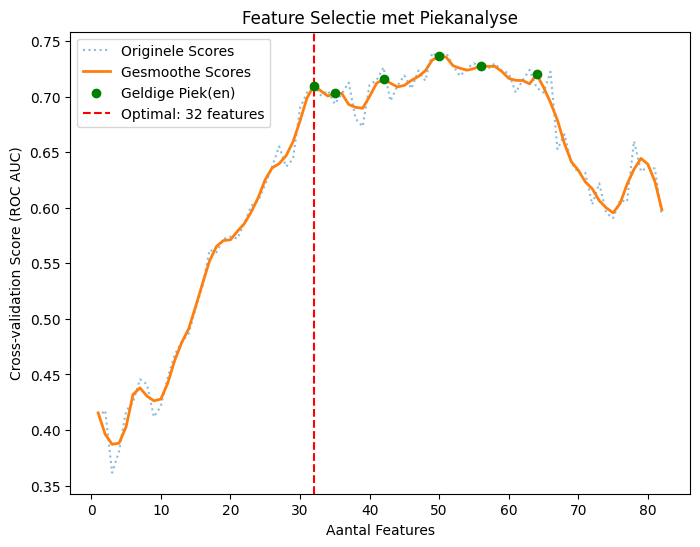

Optimale aantal features gekozen: 32


In [ ]:
# Feature selection by RFE
est = LogisticRegression(max_iter=500)

# classifications
rfecv = feature_selection.RFECV(
    estimator = est, step=1,
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(data_pca, y_train)

# Haal de CV-scores op
cv_scores = rfecv.cv_results_["mean_test_score"]
num_features = np.arange(1, len(cv_scores) + 1)

# Smooth de scores met Savitzky-Golay
smoothed_scores = savgol_filter(cv_scores, window_length=7, polyorder=2)  # Pas window_length aan als nodig

# Zoek pieken in de gesmoothe curve
peaks, properties = find_peaks(smoothed_scores, height=None)  # Zoekt alle pieken

# Bepaal de maximale score en de 10%-drempel
max_score = np.max(smoothed_scores)
threshold = max_score * 0.90  # 90% van de maximale score

# Filter pieken die:
# 1. Minimaal 10 features hebben
# 2. Binnen de 10% marge van de max-score zitten
valid_peaks = [p for p in peaks if num_features[p] >= 10 and smoothed_scores[p] >= threshold]

# Selecteer de eerste geschikte piek
optimal_index = valid_peaks[0] if valid_peaks else np.argmax(smoothed_scores)
optimal_features = num_features[optimal_index]

# Plot de originele en gesmoothe scores
plt.figure(figsize=(8, 6))
plt.plot(num_features, cv_scores, label="Originele Scores", alpha=0.5, linestyle="dotted")
plt.plot(num_features, smoothed_scores, label="Gesmoothe Scores", linewidth=2)
plt.scatter(num_features[valid_peaks], smoothed_scores[valid_peaks], color='g', label="Geldige Piek(en)", zorder=3)
plt.axvline(optimal_features, color='r', linestyle="--", label=f"Optimal: {optimal_features} features")
plt.xlabel("Aantal Features")
plt.ylabel("Cross-validation Score (ROC AUC)")
plt.legend()
plt.title("Feature Selectie met Piekanalyse")
plt.show()

print(f"Optimale aantal features gekozen: {optimal_features}")


In [20]:
# Feature selection with Random Forest
randomforest =  RandomForestClassifier(n_estimators = 100, random_state=42)
randomforest.fit(X_train, y_train)

feature_importance = randomforest.feature_importances_

n_importance = optimal_features
important_features = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i], reverse=True)[:n_importance]

print(important_features)

print(f"Most important features (indices): {important_features}")
print(f"Feature importances: {feature_importance[important_features]}")

[0, 21, 18, 20, 17, 314, 341, 366, 405, 40, 327, 486, 379, 71, 87, 67, 487, 335, 296, 102, 89, 443, 187, 337, 263, 92, 415, 291, 446, 30, 361, 209]
Most important features (indices): [0, 21, 18, 20, 17, 314, 341, 366, 405, 40, 327, 486, 379, 71, 87, 67, 487, 335, 296, 102, 89, 443, 187, 337, 263, 92, 415, 291, 446, 30, 361, 209]
Feature importances: [0.09665254 0.03465974 0.02485866 0.02205262 0.01862039 0.01684488
 0.01241276 0.01219964 0.01134193 0.00989249 0.00908063 0.00856501
 0.00851617 0.0082447  0.00790815 0.00788094 0.00722498 0.00697751
 0.00697716 0.00696162 0.00678863 0.00669458 0.00608218 0.00590986
 0.00579325 0.00565268 0.00562567 0.00552086 0.00540172 0.00538566
 0.00537659 0.00536404]


In [23]:
# Check for missing values in test data
missing_values = missing_values.dropna(subset=important_features)
print(missing_values)
y_missing = missing_values.loc[X_test.index]

KeyError: [0, 21, 18, 20, 17, 314, 341, 366, 405, 40, 327, 486, 379, 71, 87, 67, 487, 335, 296, 102, 89, 443, 187, 337, 263, 92, 415, 291, 446, 30, 361, 209]